# 0.0 Imports

In [118]:
import pandas as pd
import seaborn as sns
import inflection
import scikitplot as skplt

from collections             import Counter
from IPython.display         import Image
from matplotlib              import pyplot as plt
from IPython.core.display    import HTML
from boruta                  import BorutaPy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler, MinMaxScaler
from sklearn                 import ensemble as en
from sklearn.naive_bayes     import GaussianNB
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.neural_network  import MLPClassifier

## 0.1 Helper Functions

In [28]:
def notebook_setting():

    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    #plt.rcParams['figure.figsize'] = [14, 5]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

notebook_setting()
    

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Data

In [3]:
df_raw = pd.read_csv('../data/raw/train.csv')

In [5]:
df_raw.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

## 0.3 Train & Test Split

In [4]:
# define X and y
X = df_raw.iloc[:, :-1]
y = df_raw.iloc[:, -1:]

# split x and y
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1)

# concat train data
df = pd.concat([X_train, y_train], axis=1)

# 1.0 Data Description

## 1.1 Data Dimensions

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 342998 entries, 263289 to 62258
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    342998 non-null  int64  
 1   Gender                342998 non-null  object 
 2   Age                   342998 non-null  int64  
 3   Driving_License       342998 non-null  int64  
 4   Region_Code           342998 non-null  float64
 5   Previously_Insured    342998 non-null  int64  
 6   Vehicle_Age           342998 non-null  object 
 7   Vehicle_Damage        342998 non-null  object 
 8   Annual_Premium        342998 non-null  float64
 9   Policy_Sales_Channel  342998 non-null  float64
 10  Vintage               342998 non-null  int64  
 11  Response              342998 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.0+ MB


In [8]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
263289,263290,Male,47,1,35.0,1,1-2 Year,No,33381.0,124.0,275,0
295956,295957,Female,40,1,46.0,0,1-2 Year,Yes,31453.0,124.0,181,0
29769,29770,Female,27,1,28.0,1,< 1 Year,No,68311.0,152.0,40,0
306660,306661,Male,34,1,28.0,0,1-2 Year,Yes,26458.0,26.0,64,1
27961,27962,Female,73,1,28.0,1,1-2 Year,Yes,45124.0,122.0,267,0


## 1.2 Descriptive Statistics

### Numerical

In [9]:
desc = df[['Age', 'Annual_Premium', 'Vintage']]
ds2 = desc.describe().T
ds = pd.DataFrame(desc.skew())
ds1 = pd.DataFrame(desc.kurtosis())
stats = pd.concat([ds2, ds, ds1], axis=1)
stats.columns = ['count', 'mean','std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurtosis']
stats

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Age,342998.0,38.828121,15.513370,20.0,25.0,36.0,49.0,85.0,0.671507,-0.566635
Annual_Premium,342998.0,30558.717278,17193.044525,2630.0,24405.0,31663.0,39402.0,540165.0,1.731644,33.129994
Vintage,342998.0,154.387381,83.693830,10.0,82.0,154.0,227.0,299.0,0.003128,-1.200941


### Categorical

In [10]:
catt = df[['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured',
            'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']]
catt.apply( lambda x: x.unique().shape[0])

Gender                    2
Driving_License           2
Region_Code              53
Previously_Insured        2
Vehicle_Age               3
Vehicle_Damage            2
Policy_Sales_Channel    153
dtype: int64

# 2.0 Feature Engineering

In [5]:
df1 = df.copy()

## 2.1 Rename Columns

In [6]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']
snake_case = lambda x: inflection.underscore(x)
cols_new = list(map(snake_case, cols_old))

# Rename
df1.columns = cols_new

## 2.2 Feature Engineering

In [7]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
131991,131992,Female,20,1,3.0,1,1-2 Year,No,2630.0,156.0,92,0
100498,100499,Female,28,1,36.0,0,< 1 Year,Yes,32774.0,152.0,266,0
302358,302359,Male,58,1,46.0,0,> 2 Years,Yes,2630.0,26.0,219,1
242553,242554,Female,51,1,11.0,1,1-2 Year,No,28231.0,124.0,88,0
90046,90047,Female,46,1,28.0,0,1-2 Year,Yes,37067.0,26.0,141,0


### Average Annual Premium by Region code

In [8]:
# Average Annual premium per region code
aux1 = df1[['region_code', 'annual_premium']].groupby('region_code').mean().reset_index()

# Merge with the original dataset
aux1.rename(columns={'annual_premium': 'mean_premium_by_code'}, inplace=True)
df1 = pd.merge(df1, aux1, on='region_code', how='left')

### Insurance by Region Code

In [9]:
# Insured by code
df10 = df1[df1['previously_insured'] == 1 ]
aux1 = df10[['previously_insured', 'region_code']].groupby('region_code').count().reset_index()


# Merge with the original dataset
aux1.rename(columns={'previously_insured': 'previously_insured_by_code'}, inplace=True)
df1 = pd.merge(df1, aux1, on='region_code', how='left')

### Features Changes

In [10]:
# Vahicle Damage
df1['vehicle_damage'] = df1['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vahicle Age
df1['vehicle_age'] = df1['vehicle_age'].apply( lambda x: '1-2' if x == '1-2 Year' else '<1' if x == '> 2 Years' else '>2' )

# Gender
df1['gender'] = df1['gender'].apply( lambda x: 0 if x == 'Male' else 1 )

In [11]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,mean_premium_by_code,previously_insured_by_code
0,131992,1,20,1,3.0,1,1-2,0,2630.0,156.0,92,0,24568.549456,4089
1,100499,1,28,1,36.0,0,>2,1,32774.0,152.0,266,0,29323.481787,3812
2,302359,0,58,1,46.0,0,<1,1,2630.0,26.0,219,1,27200.744069,9237
3,242554,1,51,1,11.0,1,1-2,0,28231.0,124.0,88,0,27663.053688,5091
4,90047,1,46,1,28.0,0,1-2,1,37067.0,26.0,141,0,38675.181772,29853


# 3.0 Data Filtering

# 4.0 EDA

In [13]:
df2 = df1.copy()

## 4.1 Hypothesis Map

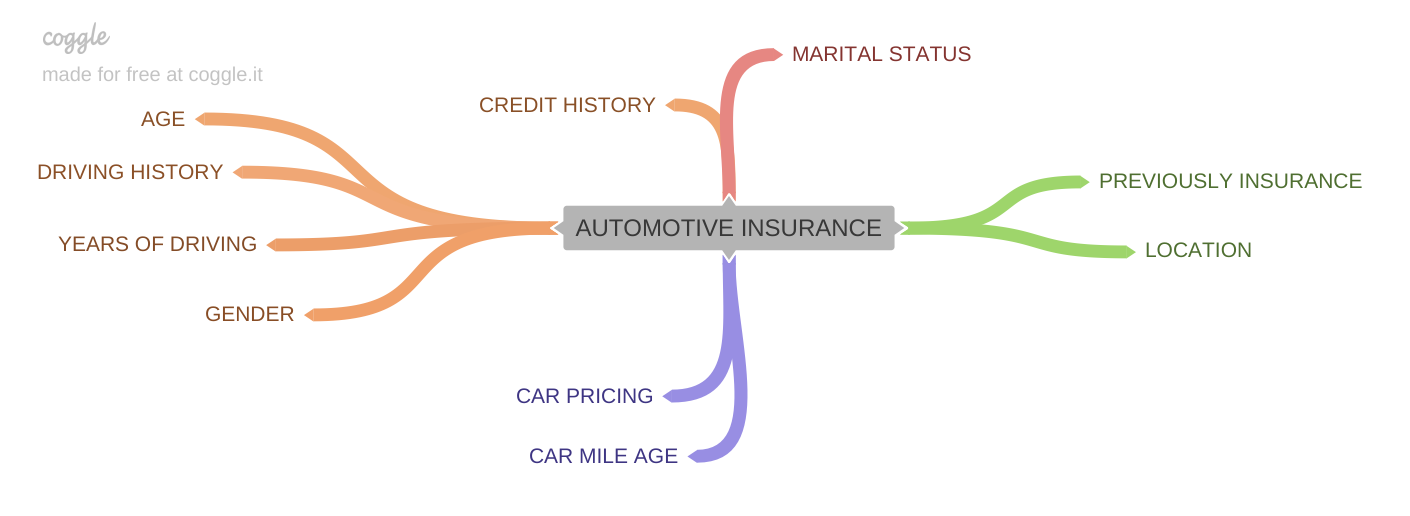

In [141]:
path = '../src/visualization/AUTOMOTIVE_INSURANCE.png'
Image(path)

## 4.2 Univariate Analysis

### Gender

In [142]:
Counter(df2['gender'])

Counter({0: 185516, 1: 157482})

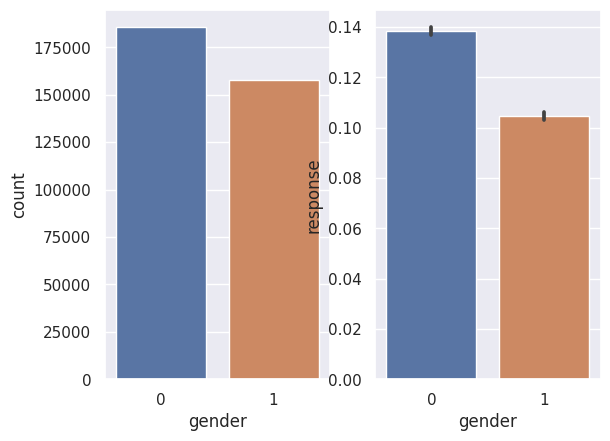

In [143]:
plt.subplot(1, 2, 1)
sns.countplot(x='gender', data=df2); # Count

plt.subplot(1, 2, 2)
sns.barplot(x='gender', y='response', data=df2); # Gender vs Response

In [144]:
# Annual premium by gender
df2[['annual_premium', 'gender']].groupby('gender').mean().reset_index()

,gender,annual_premium
0,0,30619.540056
1,1,30465.727474


### Age

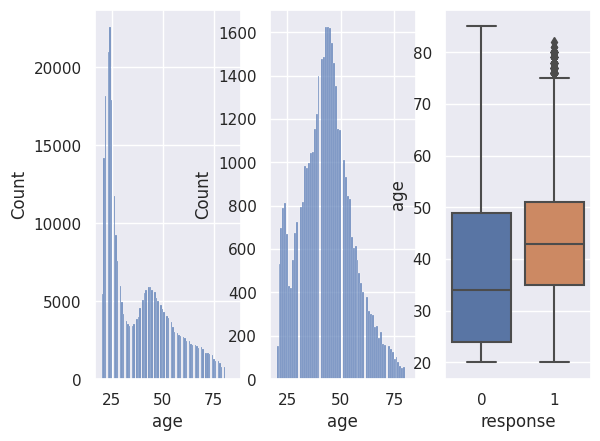

In [145]:
# response = 0 
plt.subplot(1, 3, 1)
aux0 = df2[df2['response'] == 0]
sns.histplot( aux0['age'] );

# response = 1
plt.subplot(1, 3, 2)
ax = df2[df2['response'] == 1]
sns.histplot(ax['age']);

# boxplot
plt.subplot(1, 3, 3)
sns.boxplot(x='response', y='age', data=df2);

### Driving License

In [146]:

df2[['driving_license', 'response']].groupby('driving_license').count().reset_index()

,driving_license,response
0,0,734
1,1,342264


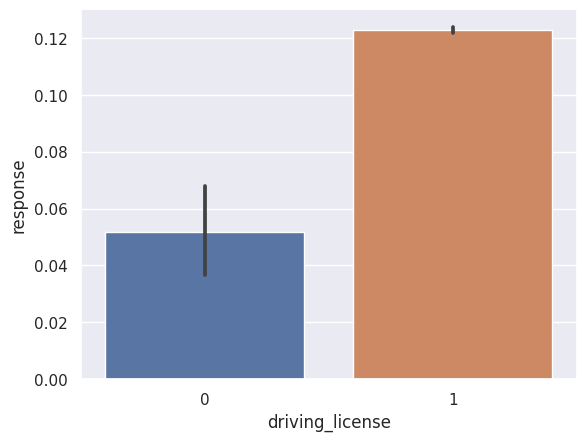

In [147]:
sns.barplot(x='driving_license', y='response', data=df2);

### Region Code

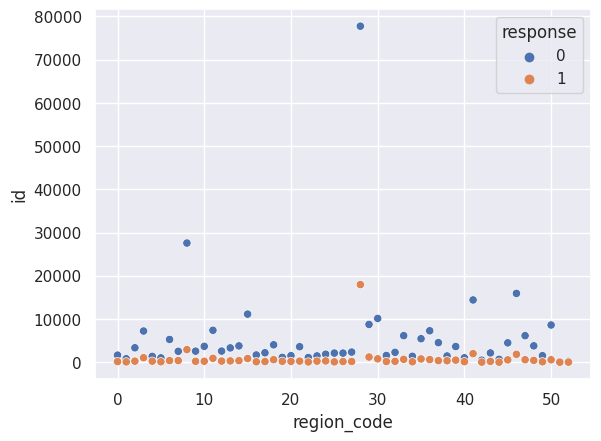

In [148]:
aux1 = df2[['region_code', 'response', 'id']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux1);

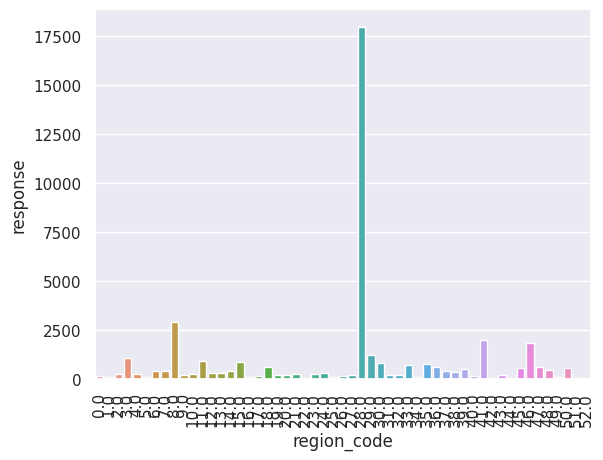

In [149]:
# Positive response per region code
aux2 = df1[df1['response'] == 1]
aux3 = aux2[['response', 'region_code']].groupby('region_code').count().reset_index()
sns.barplot(x='region_code', y='response', data=aux3);
plt.xticks(rotation=90);


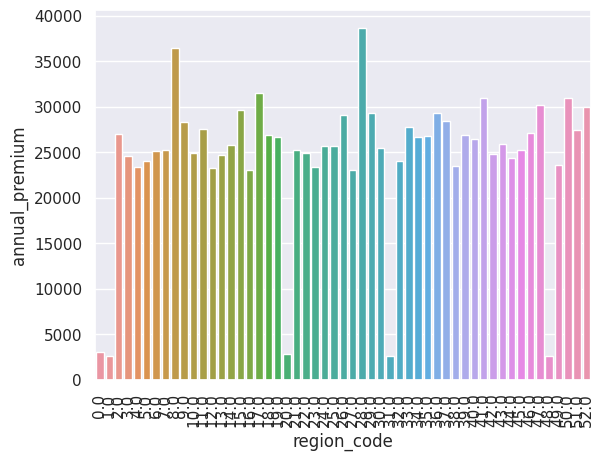

In [150]:
# Average Annual premium by region code
aux1 = df2[['region_code', 'annual_premium']].groupby('region_code').mean().reset_index()
sns.barplot(x='region_code', y='annual_premium', data=aux1);
plt.xticks(rotation=90);

In [151]:
# Annual premium >= mean region
aux2 = df2[ df2['annual_premium'] >= df2['mean_premium_by_code'] ]
count = Counter(aux2['response'])
one = (count[1]/(count[0] + count[1])) * 100
print('There are {:.2f}% of positive response'.format(one))

There are 11.98% of positive response


In [152]:
# Annual premium < mean region
aux3 = df2[ df2['annual_premium'] < df2['mean_premium_by_code'] ]
count1 = Counter(aux3['response'])
one = (count1[1]/(count1[0] + count1[1])) * 100
print('There are {:.2f}% of positive response'.format(one))


There are 12.64% of positive response


### Previously Insured

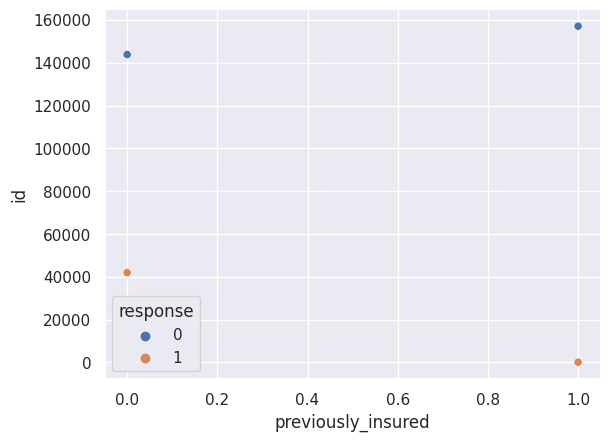

In [153]:
aux1 = df2[['id', 'response', 'previously_insured']].groupby(['previously_insured', 'response']).count().reset_index()
sns.scatterplot(x='previously_insured', y='id', hue='response', data=aux1);

In [154]:
pd.crosstab(df2['previously_insured'], df2['response']).apply( lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774124,0.225876
1,0.999071,0.000929


### Vahicle Age

In [155]:
Counter(df2['vehicle_age'])

Counter({'1-2': 180123, '>2': 148357, '<1': 14518})

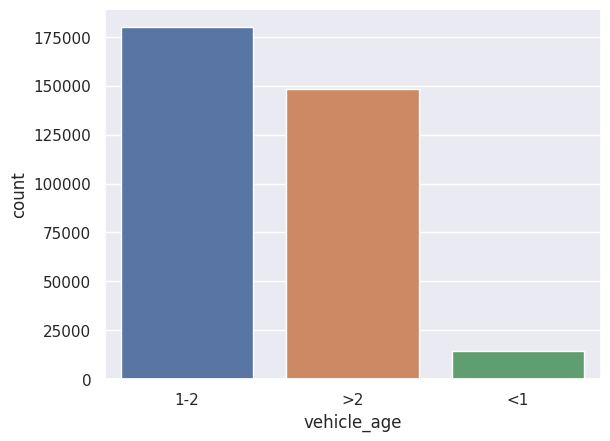

In [156]:
sns.countplot(x='vehicle_age', data=df2);

In [157]:
aux = df2[['id', 'response', 'vehicle_age']].groupby(['vehicle_age', 'response']).count().reset_index()
#sns.barplot(x='vehicle_age', y='id', hue='response', data=df2);
aux

,vehicle_age,response,id
0,1-2,0,148756
1,1-2,1,31367
2,<1,0,10245
3,<1,1,4273
4,>2,0,141883
5,>2,1,6474


In [158]:
fil = df2[df2['response'] == 1]
fil[['id', 'response', 'vehicle_age']].groupby(['vehicle_age', 'response']).count().reset_index()

,vehicle_age,response,id
0,1-2,1,31367
1,<1,1,4273
2,>2,1,6474


### Vehicle Damage

In [159]:
df2[['vehicle_damage', 'response']].groupby('response').count().reset_index()

,response,vehicle_damage
0,0,300884
1,1,42114


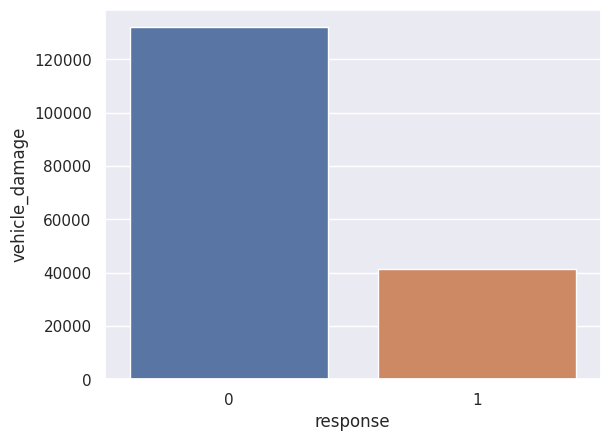

In [160]:
aux = df2[['vehicle_damage', 'response']].groupby('response').sum().reset_index()
sns.barplot(x='response', y='vehicle_damage', data=aux);

### Annual Premium

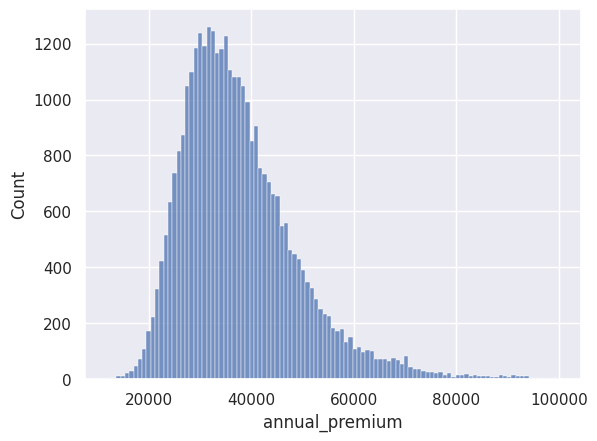

In [161]:
# Only positive answer
fil1 = df2[(df2['response'] == 1) & (df2['annual_premium'] > 10000) & (df2['annual_premium'] < 100000)]
sns.histplot(x='annual_premium', data=fil1);

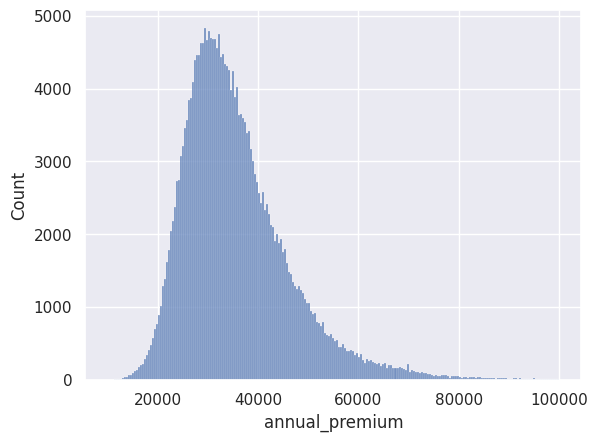

In [162]:
# Only negative asnwer
fil2 = df2[(df2['response'] == 0) & (df2['annual_premium'] > 10000) & (df2['annual_premium'] < 100000)]
sns.histplot(x='annual_premium', data=fil2);

In [164]:
sns.boxplot(x='response', y='annual_premium', data=df3);

NameError: name 'df3' is not defined

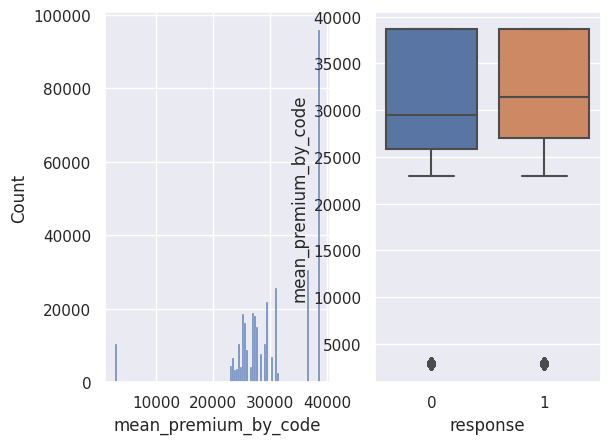

In [ ]:
plt.subplot(1, 2, 1)
sns.histplot(x='mean_premium_by_code', data=df2);

plt.subplot(1, 2, 2)
sns.boxplot(x='response', y='mean_premium_by_code', data=df2);

### Policy Sales Channel

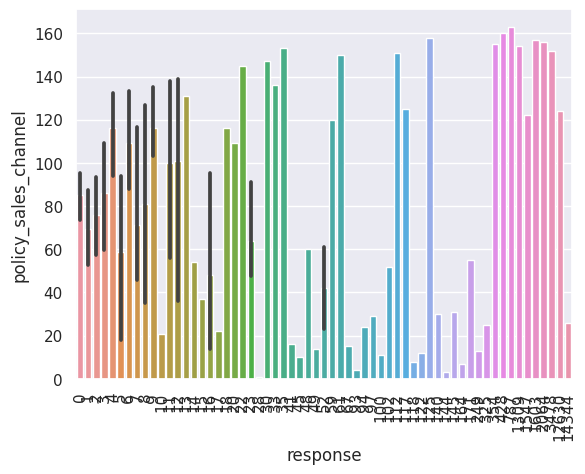

In [ ]:
fil1 = df3[['response', 'policy_sales_channel']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=fil1);
plt.xticks(rotation=90);

### Vintage

<Axes: xlabel='vintage', ylabel='Count'>

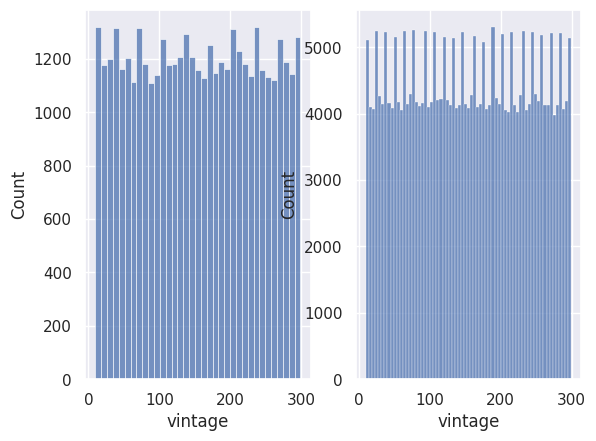

In [ ]:
plt.subplot(1, 2, 1)
fil = df2[df2['response'] == 1 ]
sns.histplot(x='vintage', data=fil);

plt.subplot(1, 2, 2)
fil2 = df2[df2['response'] == 0]
sns.histplot(x='vintage', data=fil2)

# 5.0 Data Preparation

In [12]:
df4 = df1.copy()

## 5.1 Standardization

In [13]:
# Define the scaler
ss = StandardScaler()

# Annual Premium
df4['annual_premium'] = ss.fit_transform(df4[['annual_premium']].values) 

# Mean premium by code
df4['mean_premium_by_code'] =  ss.fit_transform(df4[['mean_premium_by_code']].values)

## 5.2 Rescaling

In [14]:
mm = MinMaxScaler()

# Age
df4['age'] = mm.fit_transform(df4[['age']].values)

# vintage
df4['vintage'] = mm.fit_transform(df4[['vintage']].values)

# previously_insured_by_code
df4['previously_insured_by_code'] = mm.fit_transform(df4[['previously_insured_by_code']].values)

## 5.3 Transformation

### Encoding

In [15]:
# Region code
t_encoder_region = df4.groupby('region_code')['response'].mean()
df4.loc[:, 'region_code'] = df4['region_code'].map(t_encoder_region)


# vehicle age
df4 = pd.get_dummies(df4, prefix='vehicle_age', columns=['vehicle_age'])
df4['vehicle_age_1-2'] = df4['vehicle_age_1-2'].astype(int) 
df4['vehicle_age_<1'] = df4['vehicle_age_<1'].astype(int)
df4['vehicle_age_>2'] = df4['vehicle_age_>2'].astype(int)

# policy sales channel
frequency_channel = df4.groupby('policy_sales_channel').size() / len(df4)
df4.loc[:, 'policy_sales_channel'] = df4['policy_sales_channel'].map(frequency_channel)


In [16]:
df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,mean_premium_by_code,previously_insured_by_code,vehicle_age_1-2,vehicle_age_<1,vehicle_age_>2
0,131992,1,0.000000,1,0.125822,1,0,-1.627326,0.028015,0.283737,0,-0.812677,0.135146,1,0,0
1,100499,1,0.123077,1,0.080086,0,1,0.128243,0.353361,0.885813,0,-0.169010,0.125848,0,0,1
2,302359,0,0.584615,1,0.103510,0,1,-1.627326,0.209345,0.723183,1,-0.456362,0.307956,0,1,0
3,242554,1,0.476923,1,0.114752,1,0,-0.136339,0.194424,0.269896,0,-0.393779,0.168781,1,0,0
4,90047,1,0.400000,1,0.187371,0,1,0.378265,0.209345,0.453287,0,1.096914,1.000000,1,0,0


# 6.0 Feature Selection

## 6.1 Split Train & Validation

In [147]:
df5 = df4.copy()

In [149]:
# Split Train and Validation
X = df5.drop(['id','response'], axis=1)
y = df5['response'].copy()
X_train, X_validation, y_train, y_validation = train_test_split( X, y, test_size=0.2)

# Train and test for boruta
X_b = X_train.values
y_b = y_train.values.ravel()

## 6.2 Fature Selection

### Boruta

In [26]:
# Define Random forest
rf = RandomForestRegressor(n_jobs=1)
# Define boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_b, y_b)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	12
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	12
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	12
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	12
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	12
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	12
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	12
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	12
Iteration: 	16 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	13
I

In [31]:
cols_selected = boruta.support_.tolist()
X_fs = X_train.copy()
cols_boruta = X_fs.iloc[:, cols_selected].columns.to_list()

In [32]:
cols_boruta

['vehicle_damage']

### Fature Importance

In [39]:
rf= en.RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=1).fit(X_train, y_train)

Feature Importance Ranking
                      feature  importance
0                     vintage    0.282351
0              annual_premium    0.251206
0                         age    0.164925
0        policy_sales_channel    0.076789
0              vehicle_damage    0.071256
0          previously_insured    0.048305
0                 region_code    0.025645
0        mean_premium_by_code    0.023736
0  previously_insured_by_code    0.023572
0                      gender    0.012889
0              vehicle_age_>2    0.010800
0             vehicle_age_1-2    0.005333
0              vehicle_age_<1    0.002630
0             driving_license    0.000561


Text(0.5, 1.0, 'Global Feature Importance')

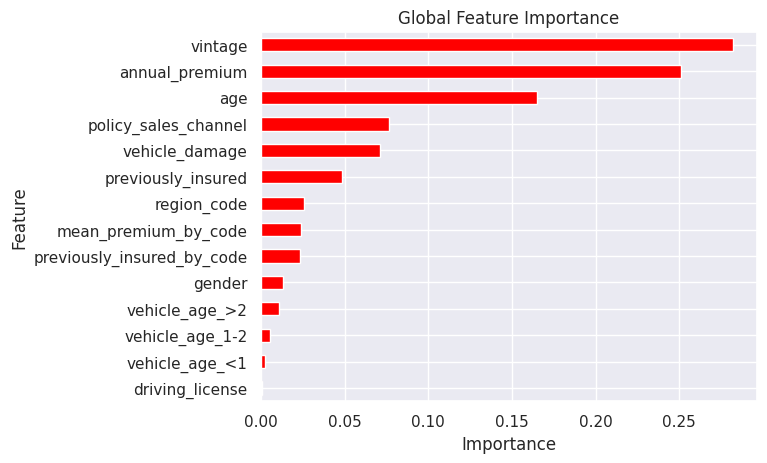

In [41]:
print('Feature Importance Ranking')
df = pd.DataFrame()
for i, j in zip( X_train, rf.feature_importances_):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
print(df.sort_values('importance', ascending=False))

global_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='red')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Global Feature Importance')

In [42]:
cols_selected = ['vintage', 'annual_premium', 'age', 'policy_sales_channel', 'vehicle_damage', 'previously_insured']

# 7.0 Machine Learnign Modeling

In [150]:
X_train = X_train[ cols_selected ]
#X_train = X_train.copy()
X_val = X_validation[ cols_selected ]
#X_val = X_validation.copy()
y_val = y_validation

In [151]:
X_train.head()

,vintage,annual_premium,age,policy_sales_channel,vehicle_damage,previously_insured
222174,0.363322,-1.627326,0.061538,0.353361,0,1
158176,0.418685,0.324452,0.261538,0.209345,1,0
321478,0.923875,0.681925,0.061538,0.353361,0,1
182817,0.041522,0.686992,0.523077,0.209345,1,0
217493,0.892734,1.363734,0.800000,0.209345,1,0


## 7.1 Model Test

### 7.1.1 Naive Bayes

In [60]:
nb = GaussianNB().fit(X_train, y_train) # Define the model
yhat_naive = nb.predict_proba( X_val )  # Make predictions

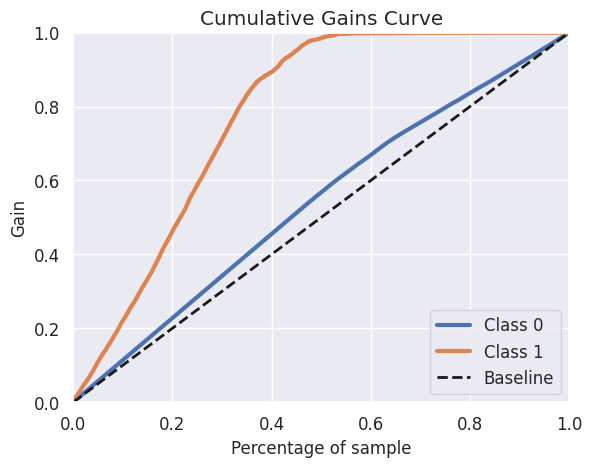

In [74]:
# Acumulation Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_naive );


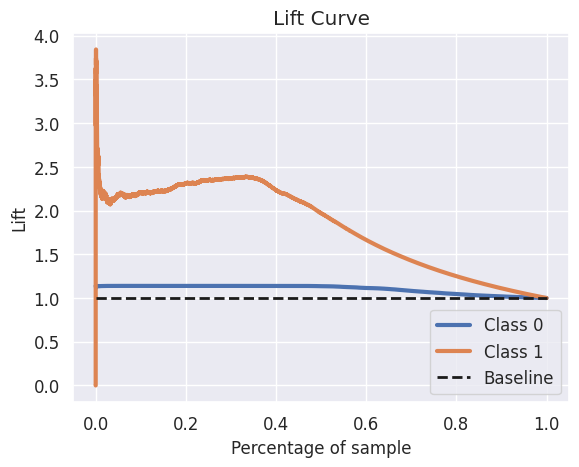

In [75]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_naive);

### 7.1.2 KNN

In [85]:
knn = KNeighborsClassifier(n_neighbors=50).fit( X_train, y_train )
yhat_knn = knn.predict_proba( X_val )

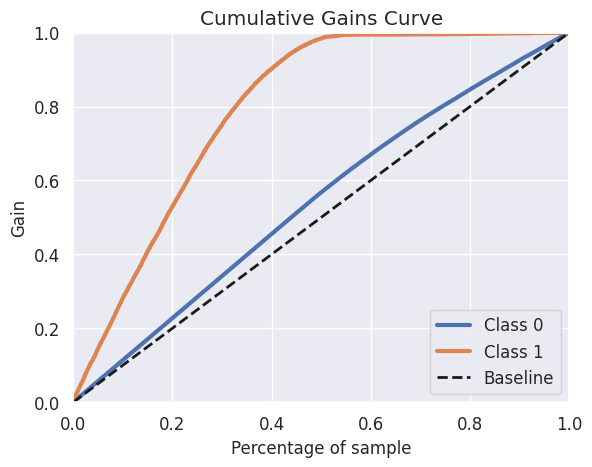

In [86]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn);

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

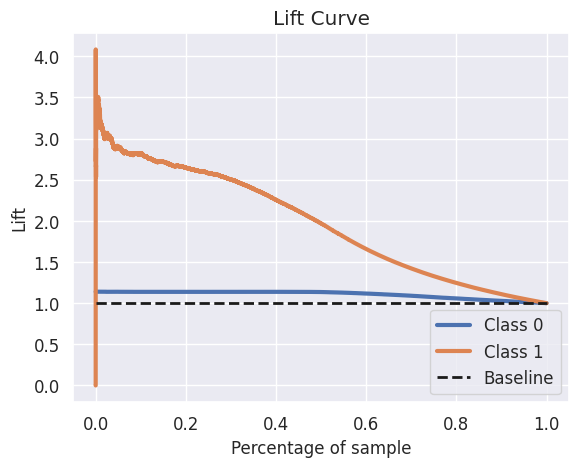

In [87]:
skplt.metrics.plot_lift_curve( y_val, yhat_knn );

### 7.1.3 Random Forest

In [98]:
rf = en.RandomForestClassifier(n_estimators=500, max_depth=100).fit( X_train, y_train )
yhat_forest = rf.predict_proba( X_val )

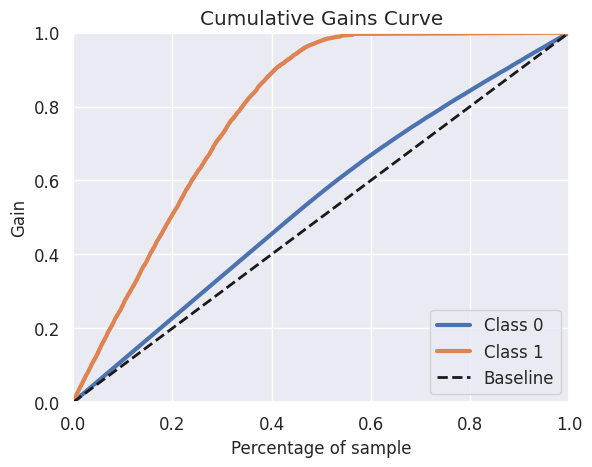

In [95]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_forest);

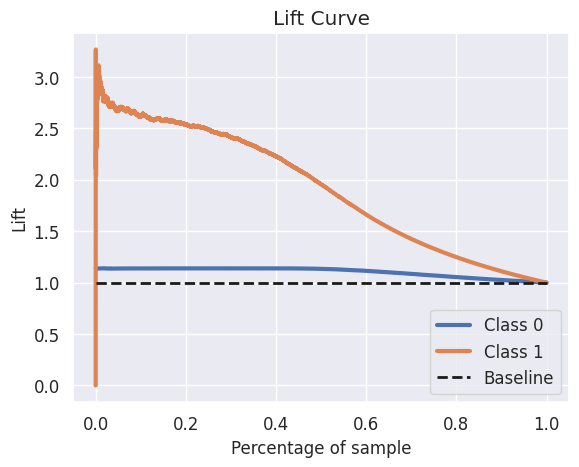

In [97]:
skplt.metrics.plot_lift_curve( y_val, yhat_forest );

### 7.1.4 Gradient Boosting

In [152]:
gb = en.GradientBoostingClassifier(n_estimators=500).fit( X_train, y_train )
yhat_gb = gb.predict_proba( X_val )

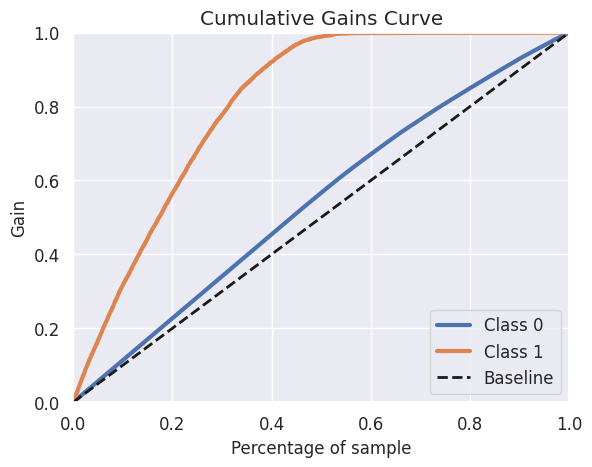

In [153]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_gb );

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

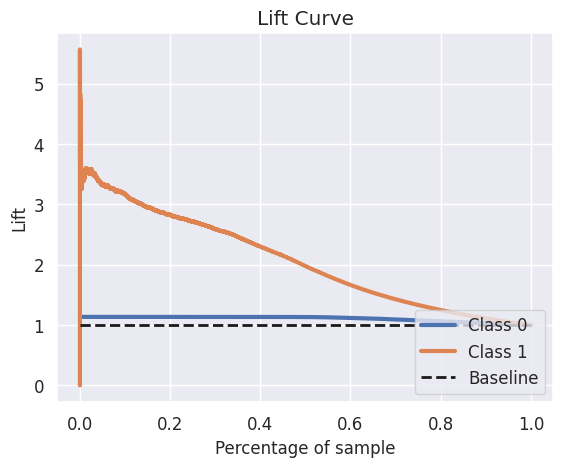

In [154]:
skplt.metrics.plot_lift_curve( y_val, yhat_gb )

### 7.1.5 Logist Regression

In [155]:
lr = LogisticRegression(random_state=42).fit( X_train, y_train)
yhat_lr = lr.predict_proba( X_val )

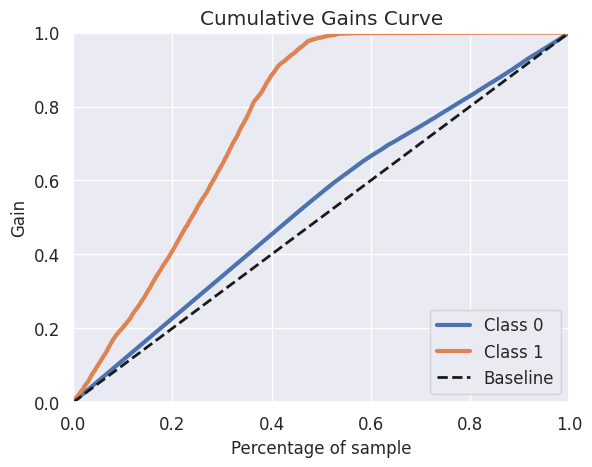

In [156]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

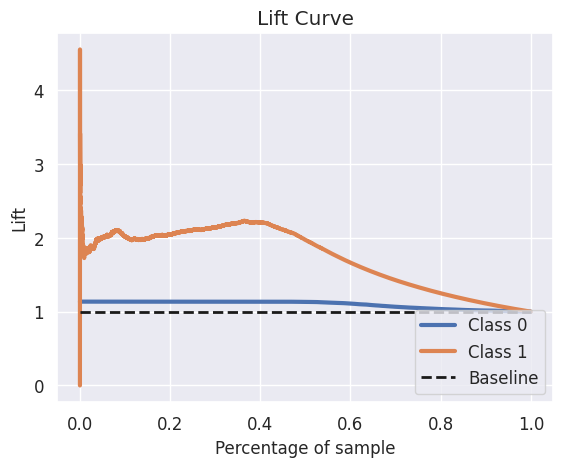

In [157]:
skplt.metrics.plot_lift_curve( y_val, yhat_lr )

### Neural Network

In [158]:
nn = MLPClassifier(hidden_layer_sizes=400,
                    activation='relu',
                    max_iter=400, 
                    random_state=42,
                    ).fit( X_train, y_train )

yhat_nn = nn.predict_proba( X_val )

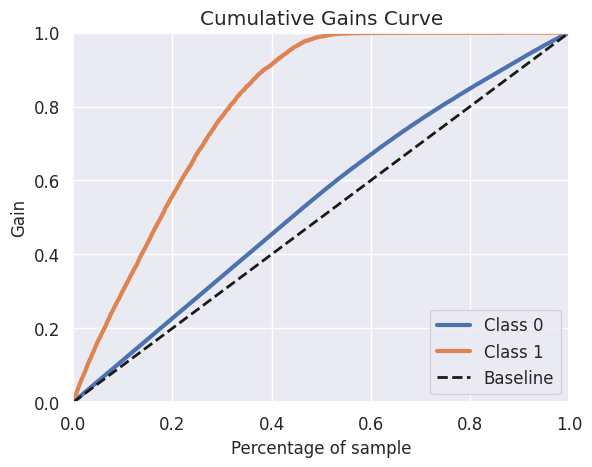

In [159]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_nn );

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

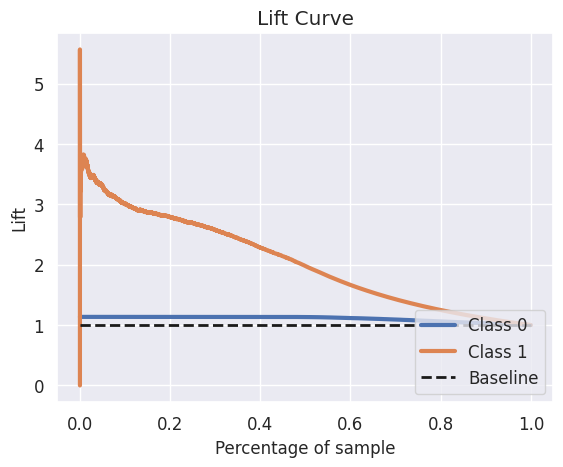

In [160]:
skplt.metrics.plot_lift_curve( y_val, yhat_nn )

## 7.3 Performance Comparation

## 7.4 Cross Validation

# 8.0 Fine Tunning

## 8.1 Random Search

## 8.2 Bayesian Search

# 9.0 Results Interpretation

# 10.0 Model to Production